<a href="https://colab.research.google.com/github/margaretmz/GANs-in-Art-and-Design/blob/main/2_DCGAN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN Fashion-MNIST
Author: Margaret Maynard-Reid

This Colab notebook is a TensorFlow 2/ Keras implementation of DCGAN, as part of the PyImageSearch University GAN series. 

The DCGAN is trained with Fashion-MNIST and generates gray-scale 28x28x1 images.

Link to the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

Table of Contents

>[DCGAN Fashion-MNIST](#scrollTo=wxWgWoUYNNYe)

>>[Import](#scrollTo=wcrOk6pURp50)

>>[Data](#scrollTo=mu11hf0_rqRq)

>>>[Loading](#scrollTo=fswXPGriDWZa)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The Generator](#scrollTo=BY-sz-IFbWr7)

>>[The Discriminator](#scrollTo=9qAUg0qNbXpS)

>>[DCGAN](#scrollTo=X0IOiEj-QNXd)

>>>[Define the DCGAN class](#scrollTo=urgSpXaPQlKk)

>>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>>[The DCGAN model - putting it together](#scrollTo=FzjTO5ZqRLVY)

>>[Compile DCGAN](#scrollTo=9OubidSS_Lrl)

>>[Train DCGAN](#scrollTo=1WhnM4ptN2rp)



## Import

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [2]:
print(tf.version.VERSION)

2.6.0


## Data
The first step is to get data ready for training.


### Loading

In [3]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


There are 60,000 training gray scale images in Fashion-MNIST.

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

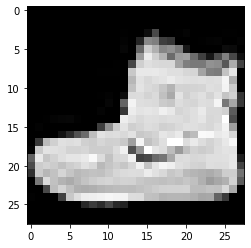

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [7]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data and create tf.data Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [10]:
def build_generator():
		# create a Keras Sequential model 
		model = Sequential(name='generator')

		# prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
		model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())

		# 1D => 3D: reshape the output of the previous layer 
		model.add(layers.Reshape((7, 7, 256)))
	
		# upsample to 14x14: apply a transposed CONV => BN => RELU
		model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
		model.add(layers.BatchNormalization())
		model.add((layers.ReLU()))
	
		# upsample to 28x28: apply a transposed CONV => BN => RELU
		model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
		model.add(layers.BatchNormalization())
		model.add((layers.ReLU()))

		# final layer: Conv2D with tanh activation
		model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

		# return the generator model
		return model

In [11]:
# build the generator model
generator = build_generator() 

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0 

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [13]:
def build_discriminator(width, height, depth, alpha=0.2):
		# create a Keras Sequential model
		model = Sequential(name='discriminator')
		input_shape = (height, width, depth)

		# first set of CONV => BN => leaky ReLU layers
		model.add(layers.Conv2D(64, (5, 5), padding="same", strides=(2, 2),
			input_shape=input_shape))
		model.add(layers.BatchNormalization())
		model.add(layers.LeakyReLU(alpha=alpha))

		# second set of CONV => BN => leacy ReLU layers
		model.add(layers.Conv2D(128, (5, 5), padding="same", strides=(2, 2)))
		model.add(layers.BatchNormalization())
		model.add(layers.LeakyReLU(alpha=alpha))

		# flatten and apply dropout
		model.add(layers.Flatten())
		model.add(layers.Dropout(0.3))

		# sigmoid in the last layer outputting a single value for binary classification
		model.add(layers.Dense(1, activation="sigmoid"))

		# return the discriminator model
		return model

In [14]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. [TODO: explain minimax objective function in tutorial, along with visual illustrations]

In [16]:
class DCGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")
  
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(DCGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):

    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
    with tf.GradientTape() as tape:
      # Compute discriminator loss on real images
      pred_real = self.discriminator(real_images, training=True)
      d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

      # Compute discriminator loss on fake images
      fake_images = self.generator(noise)
      pred_fake = self.discriminator(fake_images, training=True)
      d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

      # total discriminator loss
      d_loss = (d_loss_real + d_loss_fake)/2
    # Compute discriminator gradients
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    # Update discriminator weights
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Step 2. Train the generator (do not update weights of the discriminator)
    misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

    with tf.GradientTape() as tape:
      fake_images = self.generator(noise, training=True)
      pred_fake = self.discriminator(fake_images, training=True)
      g_loss = self.loss_fn(misleading_labels, pred_fake)
    # Compute generator gradients
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    # Update generator wieghts
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [17]:
# Create random noise seed for visualization during traing
seed = tf.random.normal([16, LATENT_DIM])

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(seed)
        generated_images *= 255
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [19]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the dcgan model, use the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** as recommended by the paper. 

In later GAN tutorials, you will learn that we can use other loss functions for other GAN variants.

In [20]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the dcgan model!

Epoch 1/50
1875/1875 [==============================] - 41s 12ms/step - d_loss: 0.1012 - g_loss: 2.2951


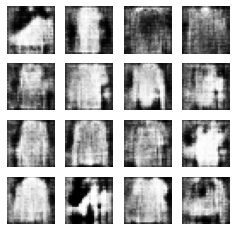

Epoch 2/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.2176 - g_loss: 2.4868


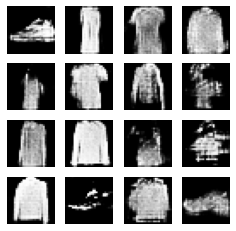

Epoch 3/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.3492 - g_loss: 2.2251


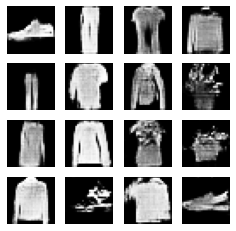

Epoch 4/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.4071 - g_loss: 1.9900


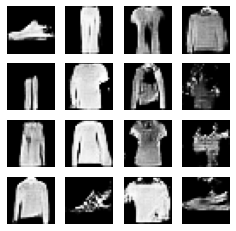

Epoch 5/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.4715 - g_loss: 1.7390


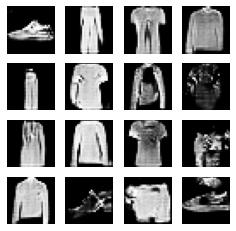

Epoch 6/50
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.4984 - g_loss: 1.5922


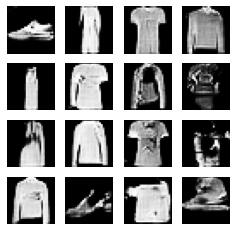

Epoch 7/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.5078 - g_loss: 1.5536


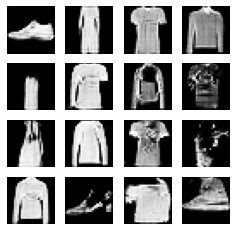

Epoch 8/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.5043 - g_loss: 1.5271


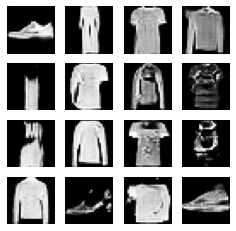

Epoch 9/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4986 - g_loss: 1.5396


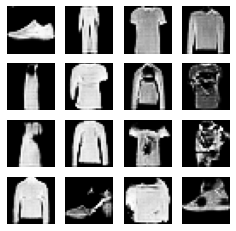

Epoch 10/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4999 - g_loss: 1.5405


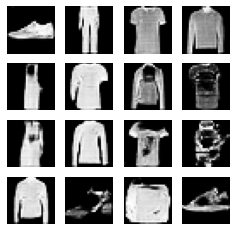

Epoch 11/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4963 - g_loss: 1.5537


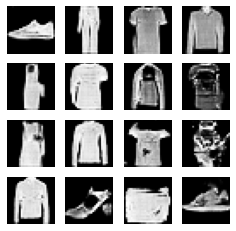

Epoch 12/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4962 - g_loss: 1.5663


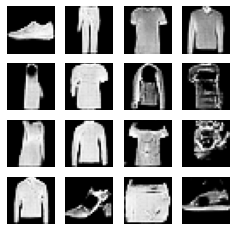

Epoch 13/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4989 - g_loss: 1.5632


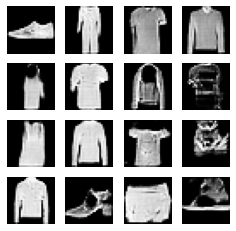

Epoch 14/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4975 - g_loss: 1.5680


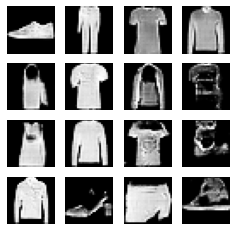

Epoch 15/50
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.4998 - g_loss: 1.5598


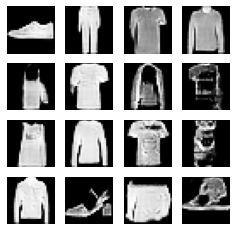

Epoch 16/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4989 - g_loss: 1.5663


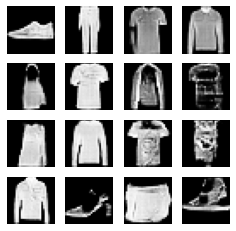

Epoch 17/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4934 - g_loss: 1.5871


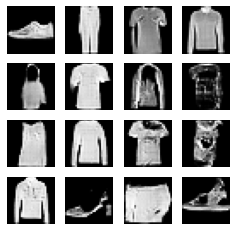

Epoch 18/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4973 - g_loss: 1.5781


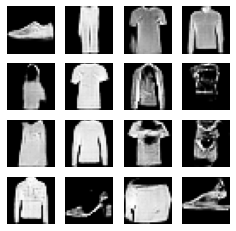

Epoch 19/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4958 - g_loss: 1.5990


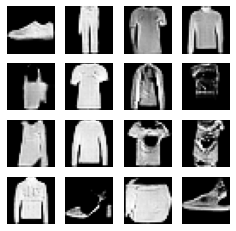

Epoch 20/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4956 - g_loss: 1.6019


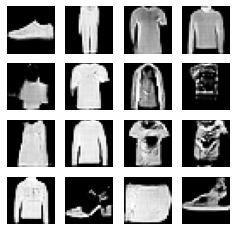

Epoch 21/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4968 - g_loss: 1.5962


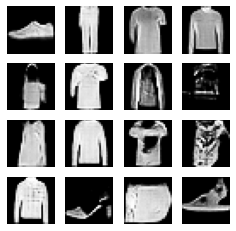

Epoch 22/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4949 - g_loss: 1.5999


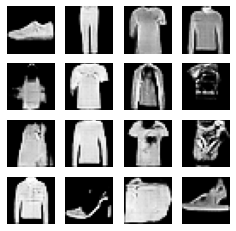

Epoch 23/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4944 - g_loss: 1.5903


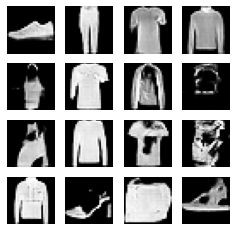

Epoch 24/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4952 - g_loss: 1.6052


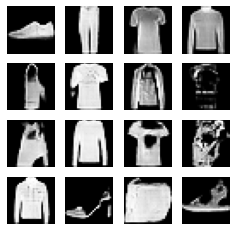

Epoch 25/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4957 - g_loss: 1.6048


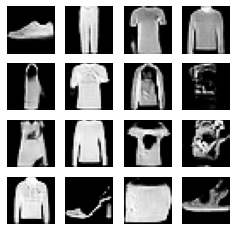

Epoch 26/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.4964 - g_loss: 1.5990


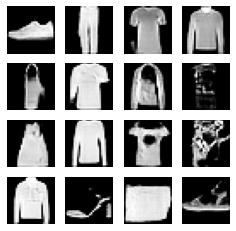

Epoch 27/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4964 - g_loss: 1.5996


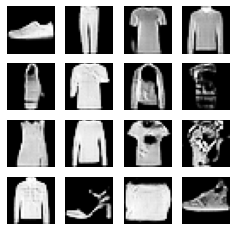

Epoch 28/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4942 - g_loss: 1.6092


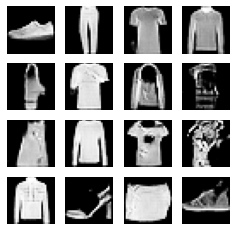

Epoch 29/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4955 - g_loss: 1.5968


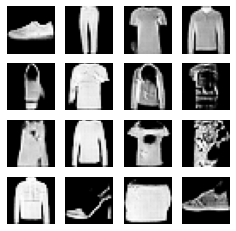

Epoch 30/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.5015 - g_loss: 1.5882


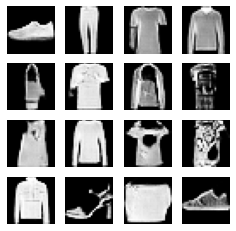

Epoch 31/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4967 - g_loss: 1.5810


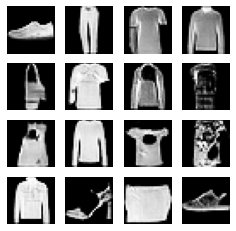

Epoch 32/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4970 - g_loss: 1.5908


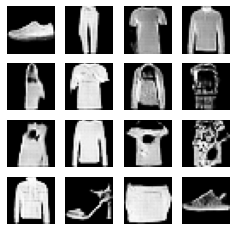

Epoch 33/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4964 - g_loss: 1.5952


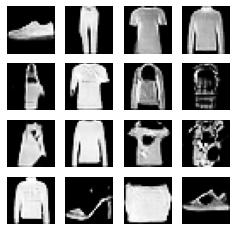

Epoch 34/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4953 - g_loss: 1.5958


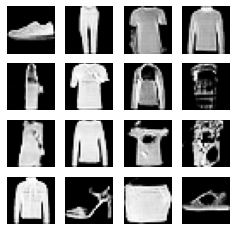

Epoch 35/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4951 - g_loss: 1.6118


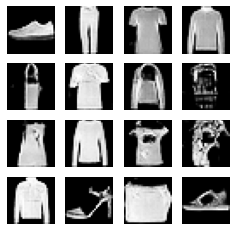

Epoch 36/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4969 - g_loss: 1.6042


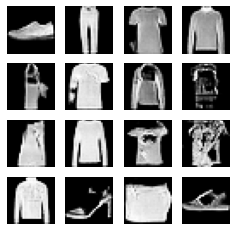

Epoch 37/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4975 - g_loss: 1.5957


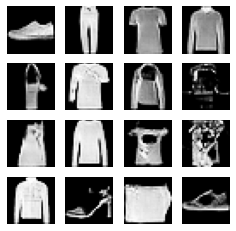

Epoch 38/50
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.4991 - g_loss: 1.5881


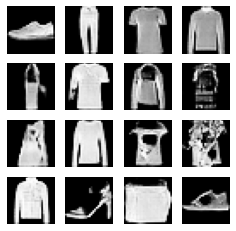

Epoch 39/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4961 - g_loss: 1.5942


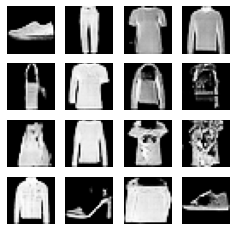

Epoch 40/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4958 - g_loss: 1.5938


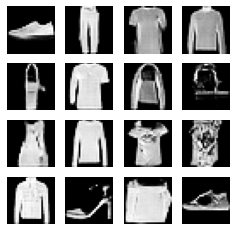

Epoch 41/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4956 - g_loss: 1.6068


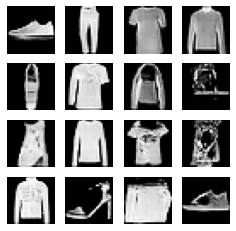

Epoch 42/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4975 - g_loss: 1.6089


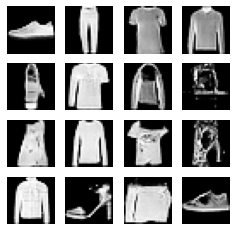

Epoch 43/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4959 - g_loss: 1.6000


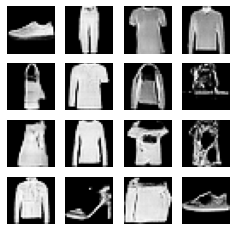

Epoch 44/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4974 - g_loss: 1.5910


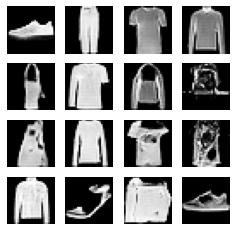

Epoch 45/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4987 - g_loss: 1.5755


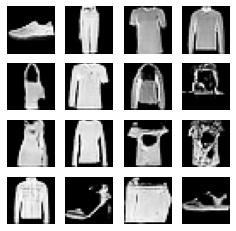

Epoch 46/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4992 - g_loss: 1.5933


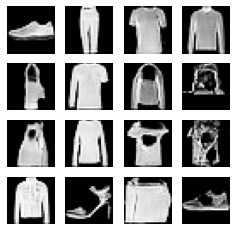

Epoch 47/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4960 - g_loss: 1.5902


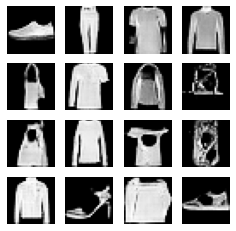

Epoch 48/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4989 - g_loss: 1.5806


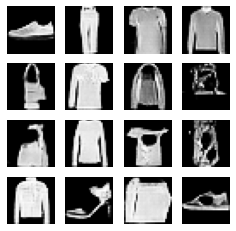

Epoch 49/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4983 - g_loss: 1.5873


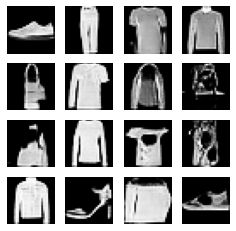

Epoch 50/50
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.4989 - g_loss: 1.5911


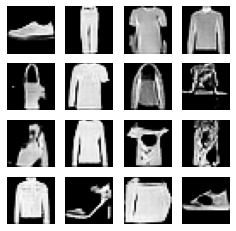

In [21]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])